In [1]:
# imports
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm


# bring in the data and make some processing with the data
TEST_DIR = "C:/Users/EPEY/cnnSKin/Data/foreHead/color/test"
TRAIN_DIR = "C:/Users/EPEY/cnnSKin/Data/foreHead/color/train"
IMG_SIZE = 50 #resize the image to 50 by 50
LR = 1e-3 #learning rate is 0.001

# 
MODEL_NAME = 'skinColor-{}-{}.model'.format(LR, '2conv-basic-video')

In [2]:
# function to get the label of the image
def label_img(img):
    word_label = img.split('.')[0][:3]
    if word_label == 'nan': return [1,0]
    elif word_label == 'emi': return [0,1]

In [3]:
# helper fxn
# create train data, labeled images
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])

    # shuffle the data
    shuffle(training_data)
    # save the training data numpy array
    # np.save('train_dataNew.npy', training_data)
    # return the traininng data
    return training_data

In [11]:
# competition text data with no label
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0] # getting the img
        #resizing the image
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    
    shuffle(testing_data)
    # save data
    # np.save('test_dataNew.npy', testing_data)
    return testing_data

In [5]:
# first run
train_data = create_train_data()
# if you already have train data
#train_data = np.load('train_data.npy')

100%|███████████████████████████████████████████████████████████████████████████| 23461/23461 [01:50<00:00, 212.42it/s]


In [9]:
# using tflearn
#cnn

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression



convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# All are labeled data
# separate the training and testing data for the accuracy of our models
train = train_data[:-500] # the train data is the last 500 sample data
test = train_data[-500:]
print("Total train data: "+str(len(train_data)))
print("Train data " + str(len(train)))
print("Test data "+ str(len(test)))

Total train data: 23461
Train data 22961
Test data 500


In [7]:
# Data getting fit
# the zero element was the image data, the pixel data
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # featured set
Y = [i[1] for i in train] # Labels

# For testing accurancy
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # featured set
test_y = [i[1] for i in test] # Labels

In [10]:
# Train the network
model.fit({'input': X}, {'targets': Y}, n_epoch=6, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME) #run id is how we will find it in tensorboard

Training Step: 2153  | total loss: 10.75955 | time: 82.339s
| Adam | epoch: 006 | loss: 10.75955 - acc: 0.5327 -- iter: 22912/22961
Training Step: 2154  | total loss: 10.97880 | time: 83.556s
| Adam | epoch: 006 | loss: 10.97880 - acc: 0.5232 | val_loss: 10.77610 - val_acc: 0.5320 -- iter: 22961/22961
--


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [02:35<00:00, 80.56it/s]


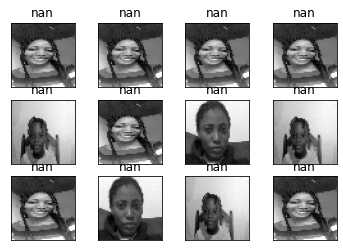

In [12]:
#imports
import matplotlib.pyplot as plt

# if you don't have this file yet
test_data = process_test_data()

# if you already have it
#test_data = np.load('test_data.npy')

# create our figure
fig = plt.figure()

# iterate thro the first 12 testing data and plot them up on a figure 
# and also put it up as a title of what the classification is
for num, data in enumerate(test_data[:12]):
    # nan: [1,0]
    # emi: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1) # num starts at 0 so we add 1
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    #model prediction, the model is already loaded
    model_out = model.predict([data])[0] # we have only one prediction
    
    # getting associating the prediction to  fel or nan
    if np.argmax(model_out) == 1: str_label='emi'
    else: str_label = 'nan'
    
    # showing the orig image and setting cmap to gray even though the image is gray cause it since to get out other colors
    y.imshow(orig, cmap='gray')
    # title is string label
    plt.title(str_label)
    # not showing the axis
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()

In [13]:
# training the network

# checking if the model exists
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [14]:
MODEL_NAME = 'skinColor-{}-{}.model'.format(LR, '6conv-basic-video')

In [15]:
# helper fxn
# create train data, labeled images
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])

    # shuffle the data
    shuffle(training_data)
    # save the training data numpy array
    # np.save('train_dataNew1.npy', training_data)
    # return the traininng data
    return training_data

In [16]:
# competition text data with no label
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0] # getting the img
        #resizing the image
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    
    # save data
    # shuffle the data
    shuffle(testing_data)
    # np.save('test_dataNew1.npy', testing_data)
    return testing_data

In [17]:
train_data = create_train_data()

100%|██████████████████████████████████████████████████████████████████████████| 23461/23461 [00:13<00:00, 1765.99it/s]


In [18]:
# reset the graph (graph in tensorboard)
#import tensorflow as tf
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()

#adding the layers now
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

#
# 1
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

# 2
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

# 3
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
#

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [19]:
train = train_data[:-500] # the train data is the last 300 sample data
test = train_data[-500:]

In [20]:
# Data getting fit
# the zero element was the image data, the pixel data
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # featured set
Y = [i[1] for i in train] # Labels

# For testing accurancy
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # featured set
test_y = [i[1] for i in test] # Labels

In [21]:
# Train the network
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME) #run id is how we will find it in tensorboard

Training Step: 1794  | total loss: 0.07514 | time: 52.658s
| Adam | epoch: 005 | loss: 0.07514 - acc: 0.9967 -- iter: 22912/22961
Training Step: 1795  | total loss: 0.06762 | time: 53.800s
| Adam | epoch: 005 | loss: 0.06762 - acc: 0.9971 | val_loss: 0.00000 - val_acc: 1.0000 -- iter: 22961/22961
--


In [ ]:
# saving this model with 99% accuracy
model.save(MODEL_NAME)

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:04<00:00, 193.40it/s]


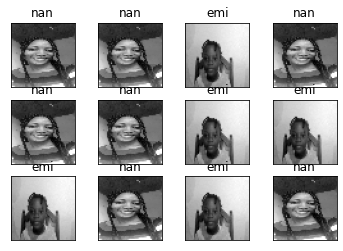

In [23]:
#imports
import matplotlib.pyplot as plt

# if you don't have this file yet
test_data = process_test_data()

# if you already have it
#test_data = np.load('test_data.npy')

# create our figure
fig = plt.figure()

# iterate thro the first 12 testing data and plot them up on a figure 
# and also put it up as a title of what the classification is
for num, data in enumerate(test_data[:12]):
    # nan: [1,0]
    # emi: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1) # num starts at 0 so we add 1
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    #model prediction, the model is already loaded
    model_out = model.predict([data])[0] # we have only one prediction
    
    # getting associating the prediction to  fel or nan
    if np.argmax(model_out) == 1: str_label='nan'
    else: str_label = 'emi'
    
    # showing the orig image and setting cmap to gray even though the image is gray cause it since to get out other colors
    y.imshow(orig, cmap='gray')
    # title is string label
    plt.title(str_label)
    # not showing the axis
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()